In [1]:
% load_ext autoreload
% autoreload 2


In [2]:
import os

if not os.getcwd().endswith('mob2crime'):
    os.chdir('..')
os.getcwd()

'/home/Jiahui/mob2crime'

In [3]:
import pandas as pd
import numpy as np
import geopandas as gp
import folium
from scipy.spatial import Voronoi, voronoi_plot_2d

from src.utils.gis import *
import src.utils.map_vis as mv
import src.mex_helper as mex
%matplotlib inline

# 20190916 overlaying TVor and loc in target Mpol

In [4]:
tvor = mex.tower_vor()
localidad = mex.localidad()

loading existing tvor file: data/mex_tower/mex_tvor_in_country.geojson
reading Localidad with polygons
reading Localidad with points
buffering point to 500
changing crs to 4326


In [5]:
rkind = 'metropolitans_all'
rname = 'metropolitan'
region = mex.regions(rkind)

In [6]:
t2loc = mex.tower2loc(500)

loading t2loc with geometry


In [8]:
mv.geojson_per_row_color_col??

In [70]:
mnames = [
    'Zona metropolitana del Valle de México',
    'Zona metropolitana de La Piedad-Pénjamo', 'Zona metropolitana de Ocotlán',
    'Zona metropolitana de Guadalajara',
    'Zona metropolitana de San Francisco del Rincón',
    'Zona metropolitana de León', 'Zona metropolitana de Tianguistenco',
    'Zona metropolitana de Cuernavaca', 'Zona metropolitana de Cuautla'
]

In [71]:
target_metro = region.loc[mnames].reset_index()

In [72]:
localidad['mun_id'] = localidad.CVE_ENT+localidad.CVE_MUN

In [73]:
mun_ids = [m for ms in target_metro.mun_ids.apply(lambda x: x.split(', ')).tolist() for m in ms]

In [74]:
target_loc = localidad[localidad.mun_id.isin(mun_ids)].reset_index()

In [75]:
target_t2l = t2loc[t2loc.localidad.isin(target_loc.loc_id)]

In [76]:
tids = target_t2l.tower.unique()

In [77]:
target_towers = tvor.loc[tids].reset_index()

In [78]:
target_t2l[target_t2l.tower=='36BA9953-36BA9954-36BA9955'].sort_values('weight', ascending=False).weight.sum()

0.5805898633531521

In [79]:
some_map = folium.Map(location=[mex.CLAT,mex.CLON], zoom_start=8)
mv.geojson_per_row(region.reset_index(),'metro', color='grey', tip_cols=['metropolitan'], some_map=some_map)
mv.geojson_per_row(target_towers, 'tower', color='blue', tip_cols=['gtid'], some_map=some_map)
mv.geojson_per_row(target_loc,'loc',color='purple',tip_cols=['loc_id','Pop'], some_map=some_map)
mv.geojson_per_row(target_t2l,'t2l',color='red',tip_cols=['tower','localidad','iPop','tower_pop','weight'], some_map=some_map)
folium.LayerControl(collapsed=False).add_to(some_map)
some_map.save(f'maps-v0916/Mex_selected_metro_tw_loc.html')

In [7]:
region

,cve_sun,mun_ids,name2,population,geometry
metropolitan,,,,,
Zona metropolitana del Valle de México,13,"09012, 09013, 09008, 09002, 09014, 09015, 0901...",Valle de M‚xico,20116842,POLYGON ((-98.67014315329796 18.99606436833296...
Zona metropolitana de Guadalajara,21,"14039, 14044, 14120, 14070, 14098, 14101, 1405...",Guadalajara,4434878,"POLYGON ((-103.286319813277 20.33274354554612,..."
Zona metropolitana de Monterrey,31,"19026, 19031, 19049, 19018, 19048, 19039, 1901...",Monterrey,4106054,"POLYGON ((-100.1068239216784 25.7014097940026,..."
Zona metropolitana de Puebla-Tlaxcala,34,"29059, 29058, 29057, 29056, 29054, 29053, 2905...",Puebla-Tlaxcala,2728790,POLYGON ((-98.41226441590273 19.11671792769241...
Zona metropolitana de Toluca,24,"15118, 15115, 15106, 15087, 15076, 15073, 1507...",Toluca,1936126,POLYGON ((-99.76956480456774 19.07640499527427...
Zona metropolitana de Tijuana,2,"02004, 02003, 02005",Tijuana,1751430,(POLYGON ((-116.675997897869 32.18521836061202...
Zona metropolitana de León,14,"11037, 11020",Le¢n,1609504,POLYGON ((-101.4978255898703 20.88094461130867...
Zona metropolitana de Juárez,11,08037,Ju rez,1332131,POLYGON ((-106.5099878267038 31.76148617278301...
Zona metropolitana de La Laguna,4,"10007, 10012, 05035, 05017",La Laguna,1215817,POLYGON ((-103.4279682574413 25.30109267747777...


# 20190909 distributed by Pop

## Vor with counts

In [5]:
tower = mex.tower_vor()

loading existing tvor file: data/mex_tower/mex_tvor_in_country.geojson


In [6]:
aver = mex.stat_tw_dow_aver_hr_uniq_user('out+in')

tw_avg_wd = pd.DataFrame(aver['wd']).T


loading cached tw average stats/stat_tw_dow_aver_hr_uniq_user-out+in.pickle


In [7]:
tw_avg_wd.columns = ['h'+c for c in tw_avg_wd.columns]

In [8]:
rkind = 'metropolitans_all'
rname = 'metropolitan'
region = mex.regions(rkind)

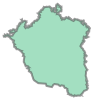

In [19]:
region.iloc[0].geometry

In [21]:
lon,lat = region.iloc[0].geometry.centroid.coords[0]
tw_df = tower[tower.geometry.apply(lambda x: x.intersects(region.iloc[0].geometry))]

In [23]:
tw_df_count = tw_df.merge(tw_avg_wd, left_index=True, right_index=True, how='left')

In [29]:
tw_df_count.fillna(0,inplace=True)

In [12]:

def geojson_per_row(gpdf, name, color='blue', tip_cols=None, some_map=None, color_col=None):
    
    if color_col:
        from branca.colormap import linear
        cmap = linear.Reds_09.scale()
        colors = gpdf[color_col].apply(cmap)
    else:
        colors = [color] * len(gpdf)
    feature_group = folium.FeatureGroup(name=name)
    for i, row in enumerate(gpdf.itertuples()):
        geom = row.geometry
        # get boundaries from geom
        if geom.type == 'Polygon':
            if geom.boundary.type == 'MultiLineString':
                lines = geom.boundary
            else:
                lines = [geom.boundary]
        else:
            lines = []
            for part in geom:
                if part.type == 'Point':
                    continue
                elif part.type == 'LineString':
                    lines.append(part)
                else:
                    lines.append(part.boundary)
        # if row.geometry.boundary.type == 'MultiLineString':
        #     lines = row.geometry.boundary
        # else:
        #     lines = [row.geometry.boundary]
        
        clr = colors[i]
        for line in lines:
            tip = '<br>'.join(
                ['%s: %s' % (col, getattr(row, col)) for col in tip_cols]) if tip_cols is not None else name

            folium.Polygon(locations=[(lat, lon) for lon, lat in line.coords], color=clr, fill_color=clr, 
                           tooltip=tip, popup=tip).add_to(feature_group)
    if some_map is not None:
        feature_group.add_to(some_map)
    return feature_group

In [24]:
tw_df_count.reset_index().columns

Index(['gtid', 'geometry', 'h0', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7',
       'h8', 'h9', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17',
       'h18', 'h19', 'h20', 'h21', 'h22', 'h23'],
      dtype='object')

In [25]:
mini = tw_df_count.h12.min()
maxi = tw_df_count.h12.max()

tw_df_count['norm'] = (tw_df_count['h12'] - mini)/(maxi-mini)

In [32]:
some_map = folium.Map(location=[lat, lon], zoom_start=6)
geojson_per_row(tw_df.reset_index(), 'tower', tip_cols=['gtid'], some_map=some_map)
geojson_per_row(tw_df_count.reset_index(), 'tower_count', color='blue', color_col='norm', tip_cols=['index', 'h12'],some_map=some_map)

folium.LayerControl().add_to(some_map)
some_map.save(f'maps/20190909MexTwCountInDf.html')

## so

In [35]:
rkind = 'metropolitans_all'
rname = 'metropolitan'
side = 1000
region = mex.regions(rkind)

In [37]:
mex_df= region.iloc[0]

In [38]:
mex_df

cve_sun                                                      13
mun_ids       09012, 09013, 09008, 09002, 09014, 09015, 0901...
name2                                           Valle de M‚xico
population                                             20116842
geometry      POLYGON ((-98.67014315329796 18.99606436833296...
Name: Zona metropolitana del Valle de México, dtype: object

In [34]:

t2loc=mex.tower2loc_by_pop()
loc2grid = mex.loc2grid_by_area(rkind, side, loc_buffer=500)

In [39]:
localidad = mex.localidad()
localidad['mun_id'] = localidad.CVE_ENT+localidad.CVE_MUN
local_in_MexDF = localidad[localidad.mun_id.isin(mex_df.mun_ids.split(', '))]

In [54]:
tInMexDF = polys2polys(tower, local_in_MexDF, area_crs=mex.AREA_CRS, pname1='tower',pname2='localidad')

In [56]:
tInMexDF = tInMexDF.iloc[:, :3]

In [57]:
t2loc_shap = gp.GeoDataFrame(t2loc.merge(tInMexDF))

In [60]:
population = mex.population_loc()

In [69]:
population[population.loc_id=='150990003'][['Población total']]

,Población total
155344,0


In [83]:
some_map = folium.Map(location=[19.381495, -99.139095], zoom_start=6)
geojson_per_row(tower.loc[set(tInMexDF.tower)].reset_index(), 'tower', color='yellow', tip_cols=['gtid'],some_map=some_map)
geojson_per_row(local_in_MexDF.reset_index(),'local',color='green',tip_cols=['loc_id'], some_map=some_map)
geojson_per_row(t2loc_shap, 'TwLocIntxn', color='blue', color_col='weight', tip_cols=['localidad', 'tower', 'weight','Pop', 'iPop', 'tower_pop'],some_map=some_map)

folium.LayerControl().add_to(some_map)
some_map.save(f'maps/20190909MexTwLocInMexDF.html')

# version on 20190212

In [46]:
# rkind = 'urban_areas_cvh_16'
rkind = 'metropolitans_16'
rname = 'metropolitan'
side=1000

# plot the vor polygons in cities
some_map = folium.Map(location=[19.381495, -99.139095], zoom_start=6)

# t2g_path = f'data/mex_tower/mex_t2g_{rkind}_{side}m.csv'

# if not redo and os.path.exists(t2g_path):
#     print('reading existing t2g file:', t2g_path)
#     t2g = pd.read_csv(t2g_path, index_col=0)
#     return t2g
t2r_intxn_only=False

tvor = mex.tower_vor()
geojson_per_row(tvor.reset_index(), 'tower vor country', color='blue', tip_cols=['gtid'],some_map=some_map)
tname = tvor.index.name

rs = mex.regions(rkind)
geojson_per_row(rs.reset_index(), f'{rkind}', color='green', tip_cols=[rname],some_map=some_map)
rname = rs.index.name

print('keep tower voronoi within', rkind, 'intersection only:', t2r_intxn_only)
t2r = polys2polys(tvor, rs, tname, rname, cur_crs=4326, area_crs=4326, intersection_only=t2r_intxn_only)
geojson_per_row(t2r.reset_index(), f'tvor in {rkind}', color='blue', tip_cols=['gtid',rname],some_map=some_map)

# overlay = gp.overlay(tvor.reset_index(), rs.reset_index())
# geojson_per_row(overlay, f'overlay', color='pink', tip_cols=['gtid','urban'],some_map=some_map)

gs = mex.grids(rkind, side)
geojson_per_row(gs, f'grids', color='yellow', tip_cols=['grid',rname],some_map=some_map)

# print('building tower to grid mapping')
# t2g = []
# for n in rs.index:
#     tr = t2r[t2r[rname] == n]
#     gr = gs[gs[rname] == n]
#     geojson_per_row(tr, f'tower in {n}', color='blue', tip_cols=['gtid'],some_map=some_map)
#     geojson_per_row(gr, f'grid in {n}', color='yellow', tip_cols=['grid'],some_map=some_map)

#     tr2gr = polys2polys(tr, gr, pname1='towerInRegion', pname2='grid', cur_crs=4326, area_crs=mex.AREA_CRS,
#                         intersection_only=True)
#     tr2gr = tr2gr.merge(tr[[tname, rname, f'{tname}_area', 'weight']], left_on='towerInRegion', right_index=True)
#     tr2gr.rename(columns={'weight_x': 'w_Grid2towerInRegion', 'weight_y': 'w_towerInRegion',
#                           'iarea': 'gridInTowerInRegion_area'}, inplace=True)
#     tr2gr['weight'] = tr2gr.w_Grid2towerInRegion * tr2gr.w_towerInRegion
#     tr2gr = tr2gr[[rname, tname, 'towerInRegion', 'grid', 'weight', 'w_towerInRegion', 'w_Grid2towerInRegion',
#                    'gridInTowerInRegion_area', 'towerInRegion_area', 'gtid_area', 'geometry', ]]
#     t2g.append(tr2gr[[rname, tname, 'grid', 'weight']])

# t2g = pd.concat(t2g, ignore_index=True).drop(rname, axis=1)
# print('saving tower to grid mapping:', t2g_path)
# t2g.to_csv(t2g_path)

folium.LayerControl().add_to(some_map)
some_map.save(f'maps/MexTwGr{rkind}{side}.html')

loading existing tvor file: data/mex_tower/mex_tvor_in_country.geojson
keep tower voronoi within metropolitans_16 intersection only: False
reading existing grids


# Using mex_helper

In [4]:
mex_tower = mex.tower()
mex_cities = mex.cities()
mex_tvor = mex.tower_vor()
mex_t2city = mex.tower_vor('cities')
mex_t2city_incityonly = mex.tower_vor('cities',intersection_only=True)
mex_t2city= mex_t2city.merge(mex_t2city_incityonly[['gtid','iarea', 'gtid_area','weight']], on='gtid')

mex_t2city.columns = [col.replace('_x','_used').replace('_y','_raw') for col in mex_t2city.columns]

loading existing tvor file: data/mex_tvor_in_country.geojson
loading existing tvor file: data/mex_tvor_in_country.geojson
loading existing tvor file: data/mex_tvor_in_country.geojson


In [5]:
mex_tvor_not_clip = mex.tower_vor(in_country=False)

saving tvor file: data/mex_tvor_raw_vor.geojson


## tower voronoi polygons for all cities

In [6]:
# plot the vor polygons in cities
some_map = folium.Map(location=[19.381495, -99.139095], zoom_start=6)

geojson_per_row(mex_tvor_not_clip.reset_index(), 'vor_raw', color='green', tip_cols=['gtid'],some_map=some_map)
geojson_per_row(mex_tvor.reset_index(), 'vor_used', color='blue', tip_cols=['gtid'],some_map=some_map)
geojson_per_row(mex_cities.reset_index(), 'city', color='red', tip_cols=['city','population'],some_map=some_map)
geojson_per_row(mex_t2city, 'vor_associated_to_cities', color='yellow', tip_cols=['gtid','city','weight_used','weight_raw','iarea_used','gtid_area_used'],some_map=some_map)
point_per_row(mex_tower[mex_tower.gtid.isin(mex_t2city.gtid)].reset_index(), 'tower', tip_cols=['gtid'],some_map=some_map)

folium.LayerControl().add_to(some_map)
some_map.save('maps/MexTwVorInCity.html')

## pick two cities to show how the grids look like

In [35]:
mex_t2g = mex.tower2grid('cities',1000)
str_from_gp = lambda gp:'<br/>'.join(gp.gtid+': '+gp.weight.apply(lambda x: f"{x:0.02%}").values)
mex_grids = mex.grids('cities', 1000)
mex_grids = mex_grids.merge(
    mex_t2g.groupby('grid').apply(
        lambda x: str_from_gp(x)
    ).reset_index(), 
    on='grid'
)
mex_grids.rename(columns={0: 'gtid_weight'},inplace=True)

reading existing t2g file: data/mex_t2g_cities_1000m.csv
reading existing grids


In [37]:
for c in ['Tijuana, Baja California', 'Valle de Mexico, Distrito Federal']:
    print('drawing for city', c)
    lon,lat = mex_cities.loc[c].geometry.centroid.coords[0]
    tmp_city = mex_cities.loc[[c]].reset_index()
    tmp_t2city = mex_t2city[mex_t2city.city==c]
    tmp_towers = mex_tower[mex_tower.gtid.isin(tmp_t2city.gtid)].reset_index()
    tmp_grids = mex_grids[mex_grids.city==c]
    
    some_map = folium.Map(location=[lat, lon], zoom_start=10)
    geojson_per_row(tmp_city, 'city', color='red', tip_cols=['city','population'],some_map=some_map)
    geojson_per_row(tmp_t2city, 'vor', color='blue', tip_cols=['gtid','city','weight_used'],some_map=some_map)
    geojson_per_row(tmp_grids, 'grids', color='yellow', tip_cols=['grid','city','gtid_weight'],some_map=some_map)
    point_per_row(tmp_towers, 'tower', tip_cols=['gtid'],some_map=some_map)

    folium.LayerControl().add_to(some_map)
    some_map.save(f'maps/MexTwGridIn{c}.html')


drawing for city Tijuana, Baja California
drawing for city Valle de Mexico, Distrito Federal


# -----------Deprecated----------------

# Mexico tw2city

## all tower polygons

In [4]:
# get tower points
mex_tower = mex.tower()
# voronoi polygons across mexico
tw_vor_polys = lonlats2vorpolys(mex_tower.lonlat.tolist(),dataframe=True)
tw_vor_polys['gtid'] = mex_tower.gtid
tw_vor_polys.crs = mex_tower.crs
print(tw_vor_polys.gtid.value_counts().value_counts())
tw_vor_polys.set_index('gtid', inplace=True)

1    5731
Name: gtid, dtype: int64


In [6]:
# plot the vor polygons
# some_map = folium.Map(location=[19.381495, -99.139095], zoom_start=8)
# geojson_per_row(tw_vor_polys, 'vor', color='yellow', tip_cols=['gtid'],some_map=some_map)
# point_per_row(towers_shp, 'tower', tip_cols=['gtid'],some_map=some_map)

# folium.LayerControl().add_to(some_map)
# some_map.save('tmp/mexico_voronoi.html')

## tower polygons within cities(or other given regions)

In [7]:
mex_cities = mex.cities()

In [8]:
# intesect city polygons and tower polygons, 
# default weight=1 (the percentage of stats in that tower to be assigned to that city)
mex_t2c = gp.sjoin(tw_vor_polys, mex_cities)
mex_t2c['weight'] = 1

In [9]:
num_cities_per_tower = mex_t2c.groupby(level=0)['index_right'].count()
t_m_c = num_cities_per_tower[num_cities_per_tower>1]
t1c = num_cities_per_tower[num_cities_per_tower==1]

In [10]:
# for the tower polygons intersecting with multiple cities
# compute the area of each intersection
# divide the weight by the percentage of area
itxns = []
for gtid, row in mex_t2c.loc[t_m_c.index].iterrows():
    itxn = mex_cities.loc[row.index_right].geometry.intersection(tw_vor_polys.loc[gtid].geometry)
    itxns.append({'gtid': gtid, 'cname': row.index_right, 'geometry': itxn})
itxns = gp.GeoDataFrame(itxns)

itxns.crs = mex_cities.crs
itxns = itxns.to_crs(epsg=6362)
itxns['area'] = itxns.geometry.apply(lambda x: x.area)

itxns['weight'] = itxns.groupby('gtid').apply(lambda x: x.area/x.area.sum()).sort_index(level=1).values

In [11]:
columns = ['gtid','cname','weight']
tmp = mex_t2c.loc[t1c.index][['index_right','weight']].reset_index()
tmp.columns=columns
t_in_c = tmp.append(itxns[columns])
t_in_c['geometry'] = t_in_c.apply(lambda x: tw_vor_polys.loc[x.gtid].geometry.intersection(mex_cities.loc[x.cname].geometry), axis=1)
t_in_c = gp.GeoDataFrame(t_in_c)

In [12]:
# plot the vor polygons in cities
some_map = folium.Map(location=[19.381495, -99.139095], zoom_start=8)
geojson_per_row(mex_cities.reset_index(), 'city', color='red', tip_cols=['cname','population'],some_map=some_map)
geojson_per_row(t_in_c, 'vor', color='yellow', tip_cols=['gtid','cname','weight'],some_map=some_map)
point_per_row(mex_tower[mex_tower.gtid.isin(t_in_c.gtid)].reset_index(), 'tower', tip_cols=['gtid'],some_map=some_map)

folium.LayerControl().add_to(some_map)
some_map.save('data/tower_in_cities_mexico.html')

In [14]:
t_in_c.to_file('data/tower_in_cities_mexico.geojson', driver='GeoJSON')

In [18]:
t_in_c.groupby('cname')['gtid'].count().sort_values(ascending=False)

cname
Valle de Mexico, Distrito Federal    643
Monterrey, Nuevo León                326
Guadalajara, Jalisco                 269
Tijuana, Baja California             186
Mexicali, Baja California            112
Toluca de Lerdo, México               79
Cuernavaca, Morelos                   79
Chihuahua, Chihuahua                  74
Juárez, Chihuahua                     71
Acapulco de Juárez, Guerrero          68
Cancún, Quintana Roo                  62
Morelia, Michoacán de Ocampo          55
Villahermosa, Tabasco                 45
Nuevo Laredo, Tamaulipas              43
Culiacán Rosales, Sinaloa             41
Oaxaca de Juárez, Oaxaca              39
Name: gtid, dtype: int64